In [3]:
from osgeo import gdal
gdal.UseExceptions()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance as dst
import os
import datetime as dt
from herbie.archive import Herbie
import sys
import io

C:\Users\mit\anaconda3\envs\herbie\lib\site-packages\toolbox\cartopy_tools.py:60: UserWarning: Migrate to `cartopy_tools2` for latest updates and features.
  warnings.warn("Migrate to `cartopy_tools2` for latest updates and features.")


In [2]:
def get_fire_grid_bounds(bbox, scale, buffer=0):
    
    # in case I want to add some buffer around the bbox
    if buffer != 0:
        raise NotImplementedError("Fire grid buffer not implemented")
    
    # get the local miles per degree longitude, miles per degree latitude
    miles_per_lon, miles_per_lat = local_miles_per_lon_lat(bbox)
    
    # translate the scale in miles to a (lon, lat) resolution
    lon_res = scale / miles_per_lon
    lat_res = scale / miles_per_lat
    
    # extract the bounds to variables
    lon_min = bbox[0]
    lon_max = bbox[2]
    lat_min = bbox[1]
    lat_max = bbox[3]
    
    # find the length of the axes in the grid we will create
    lon_ticks = (lon_max - lon_min) / lon_res
    lat_ticks = (lat_max - lat_min) / lat_res
    
    # buffer this grid to a whole number of ticks in each dimension
    lon_buffer = (1 - np.mod(lon_ticks, 1))
    if lon_buffer == 1:
        lon_buffer = 0
    lon_buffer = lon_buffer * lon_res
    lat_buffer = (1 - np.mod(lat_ticks, 1))
    if lat_buffer == 1:
        lat_buffer = 0
    lat_buffer = lat_buffer * lat_res
    new_bbox = [lon_min - lon_buffer/2, lat_min - lat_buffer/2, 
                lon_max + lon_buffer/2, lat_max + lat_buffer/2]
    
    # return the resolutions and buffered bounding box
    return lon_res, lat_res, new_bbox
    
    

In [3]:
def local_miles_per_lon_lat(bbox, k=100):
    
    # get lat, lon of center of bbox
    lat = (bbox[3] + bbox[1]) / 2
    lon = (bbox[2] + bbox[0]) / 2
    
    # get points very close to each other that vary a little bit in latitiude direction
    # note: dst.distance uses (lat, lon) convention
    coords1 = (lat - 1 / k, lon)
    coords2 = (lat + 1 / k, lon)
    
    # find miles per degree latitude
    miles_per_lat = dst.distance(coords1, coords2).miles * k / 2
    
    # get points very close to each other that vary a little bit in longitude direction
    coords1 = (lat, lon - 1 / k)
    coords2 = (lat, lon + 1 / k)
    
    # find miles per degree longitude
    miles_per_lon = dst.distance(coords1, coords2).miles * k / 2

    return miles_per_lon, miles_per_lat

In [259]:
def generate_static_data(params_df, lon_res, lat_res, fire_grid_bbox, out_path):
    
    # initialize list of vrt files that will comprise output data set
    vrts = []
    
    # for each static parameter
    for _, row in params_df.iterrows():
        
        # get the path to the data set and open it
        path = row['path']
        ds = gdal.Open(path)
        
        # get the name of the layer, and define a path to a .vrt file we will write
        layer = row['layer']
        vrt_file = f'{out_path}/{layer}.vrt'
        
        # append to list of vrt files
        vrts.append(vrt_file)
        
        # remove .vrt file if it exists (maybe not needed, but GDAL misbehaves sometimes
        # and I think it might have to do with file overwriting)
        if os.path.isfile(vrt_file):
            os.remove(vrt_file)
        
        # write a vrt file to the specified location, which links to the original dataset,
        # clips to the specific region, and reshapes the data to the proper grid
        gdal.Warp(vrt_file, ds, format='VRT', dstSRS='WGS84', xRes=lon_res, yRes=lat_res, 
                     resampleAlg=row['impute'], outputBounds=fire_grid_bbox)
    
    # define output file for all static data, delete if it exists
    out_file = f'{out_path}/static_data.vrt'
    if os.path.isfile(out_file):
        os.remove(out_file)        
    
    # build a .vrt that references all the previous .vrts, one for each layer
    # note: we cannot move any of the referenced files after doing this
    ds = gdal.BuildVRT(out_file, vrts, separate=True, allowProjectionDifference=False)
    ds.FlushCache()
    return ds
    

In [277]:
def generate_daily_fire_footprint(inc_id, ref_ds, fire_obs, fbbox, path):
    
    ex_fire = fire_obs[fire_obs['INCIDENT_IDENTIFIER'] == inc_id]
    fbbox2 = [[fbbox[1], fbbox[3]], [fbbox[0], fbbox[2]]]

    ref_ds_path = f'{path}/{inc_id}/static_data.vrt'
    ref_ds = gdal.Open(ref_ds_path)
    size = (ref_ds.RasterYSize, ref_ds.RasterXSize)
    
    SCALE = 3
    size = SCALE * np.asarray(size)

    days = list(ex_fire['ACQ_DATE'].drop_duplicates())
    if len(days) == 0:
        return 0
    first_day = dt.datetime.strptime(days[0], '%Y-%m-%d')
    last_day = dt.datetime.strptime(days[-1], '%Y-%m-%d')
    delta = last_day - first_day
    all_days = [first_day + dt.timedelta(days=i) for i in range(delta.days + 1)]
    all_days = [day.strftime('%Y-%m-%d') for day in all_days]
    
    drv = gdal.GetDriverByName("GTiff")
    width = int(size[1])
    height = int(size[0])
    ds = drv.Create(f'{path}/{inc_id}/unscaled_fire_footprint.tif', width, height, len(all_days), gdal.GDT_Float32)
    
    for i, day in enumerate(all_days):
        if i == 0:
            ex_fire_day = ex_fire.query('ACQ_DATE == @day & ACQ_TIME < 1200')
        else:
            last_day = all_days[i-1]
            ex_fire_day = ex_fire.query('(ACQ_DATE == @day & ACQ_TIME < 1200) |'
                      ' (ACQ_DATE == @last_day & ACQ_TIME >= 1200) ')
        z, y, x = np.histogram2d(ex_fire_day['LATITUDE'], ex_fire_day['LONGITUDE'], 
                                 bins=size, range=fbbox2)
        z = np.flip(z, axis=0)

        height, width = z.shape


        raster = ds.GetRasterBand(i+1)
        raster.WriteArray(z)
        raster.SetDescription(day)
        tr = np.asarray(ref_ds.GetGeoTransform())
        tr[1] /= SCALE
        tr[5] /= SCALE

        ds.SetGeoTransform(tuple(tr))

        tr = ref_ds.GetGeoTransform()
    ds2 = gdal.Warp(f'{path}/{inc_id}/daily_fire_footprint.vrt', ds, format='VRT', xRes=abs(tr[1]), yRes=abs(tr[5]), 
                             resampleAlg='cubic', outputBounds=fbbox)
    
    return ds2

In [279]:
boundaries = pd.read_pickle('data/clean/merged_boundaries.pkl')
fire_pixels_lookup = pd.read_csv('data/clean/fire_pixels_lookup.csv')
fire_pixels = pd.read_csv('data/clean/viirs.csv')

fire_pixels = pd.merge(fire_pixels, fire_pixels_lookup, on='pixel_id', how='right', validate='1:1')
fire_pixels = fire_pixels[fire_pixels['INCIDENT_IDENTIFIER'].notna()]
fire_pixels['INCIDENT_IDENTIFIER'] = fire_pixels['INCIDENT_IDENTIFIER'].astype(str)

out_path = 'data/clean/fire_histories_3'

In [1]:
import importlib
importlib.reload(fire_history)

NameError: name 'fire_history' is not defined

In [2]:
import fire_history

In [3]:
dropbox_path = r"C:\Users\mit\Dropbox (MIT)"

fire_history.preprocess(dropbox_path, gifs=True)

<Figure size 432x288 with 0 Axes>

In [5]:
fire_history.make_gifs('data/clean/fire_histories_6')

5

<Figure size 432x288 with 0 Axes>

In [281]:
df = pd.read_csv('data/input/static_data_params.csv')
dropbox_path  = r"C:\Users\mit\Dropbox (MIT)"
df['path'] = dropbox_path + "\\" + df['path']

if not os.path.isdir(out_path):
    os.mkdir(out_path)
scale = 0.6

boundaries['fire_grid_bbox'] = ''

for i, fire in boundaries.iterrows():
    
    bbox = fire['bbox']
    inc_id = fire['INCIDENT_IDENTIFIER']  
    
    if inc_id == '11926606':
        
        fire_out_path = f'{out_path}/{inc_id}'

        if not os.path.isdir(fire_out_path):
            os.mkdir(fire_out_path)

        lon_res, lat_res, new_bbox = get_fire_grid_bounds(bbox, scale)
        # boundaries.at[i, 'fire_grid_bbox'] = tuple(new_bbox)
        ds = generate_static_data(df, lon_res, lat_res, new_bbox, fire_out_path)

        a = generate_daily_fire_footprint(inc_id, ref_ds, fire_pixels, new_bbox, out_path)

In [264]:
df = pd.read_csv('data/input/static_data_params.csv')
dropbox_path  = r"C:\Users\mit\Dropbox (MIT)"
df['path'] = dropbox_path + "\\" + df['path']

if not os.path.isdir(out_path):
    os.mkdir(out_path)
scale = 0.6

boundaries['fire_grid_bbox'] = ''

for i, fire in boundaries.iterrows():
    
    bbox = fire['bbox']
    inc_id = fire['INCIDENT_IDENTIFIER']   
        
    fire_out_path = f'{out_path}/{inc_id}'

    if not os.path.isdir(fire_out_path):
        os.mkdir(fire_out_path)

    lon_res, lat_res, new_bbox = get_fire_grid_bounds(bbox, scale)
    boundaries.at[i, 'fire_grid_bbox'] = tuple(new_bbox)
    ds = generate_static_data(df, lon_res, lat_res, new_bbox, fire_out_path)

    a = generate_daily_fire_footprint(inc_id, ref_ds, fire_pixels, new_bbox, out_path)

In [248]:
a.RasterXSize, a.RasterYSize, a.RasterCount

(46, 29, 30)

In [251]:
ds.RasterXSize, ds.RasterYSize, ds.RasterCount

(46, 29, 3)

In [222]:
inc_id = '11926606'

ex_fire = fire_pixels[fire_pixels['INCIDENT_IDENTIFIER'] == inc_id]
bbox = boundaries.set_index('INCIDENT_IDENTIFIER').loc[inc_id, 'bbox']
lon_res, lat_res, fbbox = get_fire_grid_bounds(bbox, 0.6, buffer=0)
fbbox2 = [[fbbox[1], fbbox[3]], [fbbox[0], fbbox[2]]]

ref_ds_path = f'data/clean/fire_histories_2/{inc_id}/static_data.vrt'
ref_ds = gdal.Open(ref_ds_path)
size = (ref_ds.RasterYSize, ref_ds.RasterXSize)

``SCALE ~= scale / 0.2``

In [223]:
SCALE = 3
size = SCALE * np.asarray(size)

In [224]:
days = list(ex_fire['ACQ_DATE'].drop_duplicates())
first_day = dt.datetime.strptime(days[0], '%Y-%m-%d')
last_day = dt.datetime.strptime(days[-1], '%Y-%m-%d')
delta = last_day - first_day
all_days = [first_day + dt.timedelta(days=i) for i in range(delta.days + 1)]
all_days = [day.strftime('%Y-%m-%d') for day in all_days]

In [229]:
drv = gdal.GetDriverByName("GTiff")
width = int(size[1])
height = int(size[0])
ds = drv.Create("test5.tif", width, height, len(all_days), gdal.GDT_Float32)

In [230]:
for i, day in enumerate(all_days):
    if i == 0:
        ex_fire_day = ex_fire.query('ACQ_DATE == @day & ACQ_TIME < 1200')
    else:
        last_day = all_days[i-1]
        ex_fire_day = ex_fire.query('(ACQ_DATE == @day & ACQ_TIME < 1200) |'
                  ' (ACQ_DATE == @last_day & ACQ_TIME >= 1200) ')
    z, y, x = np.histogram2d(ex_fire_day['LATITUDE'], ex_fire_day['LONGITUDE'], 
                             bins=size, range=fbbox2)
    z = np.flip(z, axis=0)

    height, width = z.shape


    ds.GetRasterBand(i+1).WriteArray(z)
    tr = np.asarray(ref_ds.GetGeoTransform())
    tr[1] /= SCALE
    tr[5] /= SCALE

    ds.SetGeoTransform(tuple(tr))

    tr = ref_ds.GetGeoTransform()
ds2 = gdal.Warp(f'data/clean/fire_histories_2/{inc_id}/daily_fire_footprint.vrt', ds, format='VRT', xRes=abs(tr[1]), yRes=abs(tr[5]), 
                         resampleAlg='cubic', outputBounds=fbbox)

In [5]:
df = pd.read_csv('data/input/static_data_params.csv')
dropbox_path  = r"C:\Users\mit\Dropbox (MIT)"
df['path'] = dropbox_path + "\\" + df['path']
df

,layer,path,impute
0,evc,C:\Users\mit\Dropbox (MIT)\wildfire_repo\LF201...,near
1,slope,C:\Users\mit\Dropbox (MIT)\wildfire_repo\LF201...,bilinear
2,aspect,C:\Users\mit\Dropbox (MIT)\wildfire_repo\LF201...,near


In [6]:
boundaries = pd.read_pickle('data/clean/merged_boundaries.pkl')

In [81]:
for i, fire in boundaries.iterrows():
    
    inc_id = fire['INCIDENT_IDENTIFIER']
    fire_out_path = f'{out_path}/{inc_id}/static_data.vrt'
    try:
        a = gdal.Open(fire_out_path)
        b = a.GetRasterBand(3).ReadAsArray()
        assert b is not None
    except:
        print(inc_id)

In [140]:
def extract_hrrr(time, codes, save_dir, fxx=0):
    
    # get HRRR forecast initialization at this time (should be real-time weather)
    H = Herbie(time, model='hrrr', product='sfc', fxx=fxx, save_dir=save_dir)
    
    herbie_regex = '|'.join(codes)
    
    print(dt.datetime.now())
    original_out = sys.stdout
    new_stdout = io.StringIO()
    sys.stdout = new_stdout
    
    H.download(herbie_regex)
    
    output = new_stdout.getvalue()
    sys.stdout = original_out
    print(dt.datetime.now())
    
    l = output.split('GRIB_message')[1:]
    lookup = {code : [i for i, string in enumerate(l) if code in string] for code in codes}

    lens = list(set([len(lookup[key]) for key in lookup]))
    if lens != [1]:
        raise ValueError('Merge ambiguity for HRRR bands on download')
    
    band_lookup = {i:lookup[i][0]+1 for i in lookup}
    
    return band_lookup

In [101]:
import datetime as dt

In [133]:
fields = pd.read_csv('data/input/hrrr_fields.csv')
codes = list(fields['download_code'])

In [118]:
dropbox_path

'C:\\Users\\mit\\Dropbox (MIT)'

In [145]:
import json

In [160]:
H = Herbie(time, model='hrrr', product='sfc', fxx=fxx, save_dir='data')

herbie_regex = '|'.join(codes)

print(dt.datetime.now())
original_out = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

H.download(herbie_regex)

output = new_stdout.getvalue()
sys.stdout = original_out
print(dt.datetime.now())

🏋🏻‍♂️ Found 2020-Jan-01 00:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
2022-01-19 17:05:53.951060
2022-01-19 17:05:54.285441


In [161]:
output

'🌉 Already have local copy --> C:\\Users\\mit\\Documents\\GitHub\\wildfires\\data\\hrrr\\20200101\\hrrr.t00z.wrfsfcf00.grib2.subset_54-57-66-68-71-72-77\n'

In [ ]:
H.download(herbie_regex)

output = new_stdout.getvalue()
sys.stdout = original_out
print(dt.datetime.now())

l = output.split('GRIB_message')[1:]
lookup = {code : [i for i, string in enumerate(l) if code in string] for code in codes}

lens = list(set([len(lookup[key]) for key in lookup]))
if lens != [1]:
    raise ValueError('Merge ambiguity for HRRR bands on download')

In [168]:
import importlib
importlib.reload(weather)

<module 'weather' from 'C:\\Users\\mit\\Documents\\GitHub\\wildfires\\weather.py'>

In [170]:
codes

['TMP:2 m',
 'SPFH:2 m',
 'UGRD:10 m',
 'VGRD:10 m',
 'LTNG',
 'PRATE',
 'PRES:surface']

In [171]:
first = dt.datetime(2020, 1, 1, 12, 0)
in_path = 'data'
out_path = 'C:\\Users\\mit\\Dropbox (MIT)\\wildfire_repo'
weather.download_all_hrrr(codes, first, 3, in_path, out_path, fxx=0)

🏋🏻‍♂️ Found 2020-Jan-01 12:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
🏋🏻‍♂️ Found 2020-Jan-02 12:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
🏋🏻‍♂️ Found 2020-Jan-03 12:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       


In [237]:
del ds
del ds2

In [231]:
arr = np.asarray([ds2.GetRasterBand(i+1).ReadAsArray() for i in range(ds2.RasterCount)])

['data/clean/fire_histories_3\\11684732',
 'data/clean/fire_histories_3\\11689311',
 'data/clean/fire_histories_3\\11691297',
 'data/clean/fire_histories_3\\11691594',
 'data/clean/fire_histories_3\\11691738',
 'data/clean/fire_histories_3\\11692955',
 'data/clean/fire_histories_3\\11694233',
 'data/clean/fire_histories_3\\11695713',
 'data/clean/fire_histories_3\\11696761',
 'data/clean/fire_histories_3\\11696993',
 'data/clean/fire_histories_3\\11697391',
 'data/clean/fire_histories_3\\11697544',
 'data/clean/fire_histories_3\\11698370',
 'data/clean/fire_histories_3\\11698585',
 'data/clean/fire_histories_3\\11698619',
 'data/clean/fire_histories_3\\11700201',
 'data/clean/fire_histories_3\\11700584',
 'data/clean/fire_histories_3\\11701645',
 'data/clean/fire_histories_3\\11701776',
 'data/clean/fire_histories_3\\11701944',
 'data/clean/fire_histories_3\\11702064',
 'data/clean/fire_histories_3\\11702913',
 'data/clean/fire_histories_3\\11706093',
 'data/clean/fire_histories_3\\117

In [12]:
import os
import glob
from PIL import Image

fig = plt.figure()

for out_path in glob.glob('data/clean/fire_histories_4/*'):
    
    ds_path = f'{out_path}/daily_fire_footprint.vrt'
    if os.path.isfile(ds_path):
        
        ds = gdal.Open(ds_path)
        arr = np.asarray([ds.GetRasterBand(i+1).ReadAsArray() for i in range(ds.RasterCount)])

        ims = []
        for i, day in enumerate(arr):
            im = plt.imshow(day)
            plt.set_cmap("hot")
            plt.clim(0,1)
            plt.colorbar()
            title = ds.GetRasterBand(i+1).GetDescription()
            plt.title(title)
            plt.savefig(f'{out_path}/{str(i).zfill(4)}.png')
            plt.clf()

        fp_in = f"{out_path}/*.png"
        fp_out = f"{out_path}/daily_fire_footprint.gif"

        pngs = sorted(glob.glob(fp_in))
        img, *imgs = [Image.open(f) for f in pngs]

        duration = [200 for f in pngs]
        duration[-1] = 1000
        img.save(fp=fp_out, format='GIF', append_images=imgs,
                 save_all=True, duration=duration, loop=0)

        rm_files = [os.remove(f) for f in pngs]

<Figure size 432x288 with 0 Axes>

In [11]:
ds.GetRasterBand(i+1).GetDescription()

''

In [7]:
import glob
from PIL import Image

In [8]:
out_path = 'data/clean/fire_histories_4/11926606'
ds_path = f'{out_path}/daily_fire_footprint.vrt'
if os.path.isfile(ds_path):

    ds = gdal.Open(ds_path)
    arr = np.asarray([ds.GetRasterBand(i+1).ReadAsArray() for i in range(ds.RasterCount)])

    ims = []
    for i, day in enumerate(arr):
        im = plt.imshow(day)
        plt.set_cmap("hot")
        plt.clim(0,1)
        plt.colorbar()
        plt.title(f'{i}')
        plt.savefig(f'{out_path}/{str(i).zfill(4)}.png')
        plt.clf()

    fp_in = f"{out_path}/*.png"
    fp_out = f"{out_path}/daily_fire_footprint.gif"

    pngs = sorted(glob.glob(fp_in))
    img, *imgs = [Image.open(f) for f in pngs]

    duration = [200 for f in pngs]
    duration[-1] = 1000
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=duration, loop=0)

    rm_files = [os.remove(f) for f in pngs]

<Figure size 432x288 with 0 Axes>

In [273]:
os.path.isfile('data/clean/fire_histories_3/11980913/daily_fire_footprint.vrt')

True

In [270]:
ds_path

'data/clean/fire_histories_3\\11980913/daily_fire_footprint.vrt'

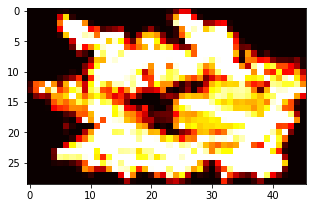

In [235]:
plt.imshow(np.amax(arr, axis=0))
plt.clim(0,1)

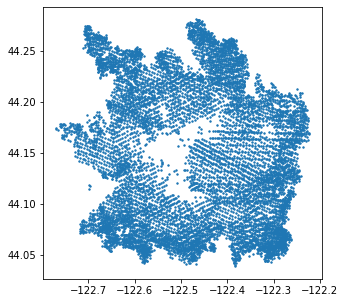

In [234]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.scatter(ex_fire['LONGITUDE'], ex_fire['LATITUDE'], s=2)

In [137]:
help(img.save)

Help on method save in module PIL.Image:

save(fp, format=None, **params) method of PIL.PngImagePlugin.PngImageFile instance
    Saves this image under the given filename.  If no format is
    specified, the format to use is determined from the filename
    extension, if possible.
    
    Keyword options can be used to provide additional instructions
    to the writer. If a writer doesn't recognise an option, it is
    silently ignored. The available options are described in the
    :doc:`image format documentation
    <../handbook/image-file-formats>` for each writer.
    
    You can use a file object instead of a filename. In this case,
    you must always specify the format. The file object must
    implement the ``seek``, ``tell``, and ``write``
    methods, and be opened in binary mode.
    
    :param fp: A filename (string), pathlib.Path object or file object.
    :param format: Optional format override.  If omitted, the
       format to use is determined from the filename ext

In [133]:
fp_in = f"{out_path}/*.png"
sorted(glob.glob(fp_in))

['sample_fig\\0.png',
 'sample_fig\\1.png',
 'sample_fig\\10.png',
 'sample_fig\\11.png',
 'sample_fig\\12.png',
 'sample_fig\\13.png',
 'sample_fig\\14.png',
 'sample_fig\\15.png',
 'sample_fig\\16.png',
 'sample_fig\\17.png',
 'sample_fig\\18.png',
 'sample_fig\\19.png',
 'sample_fig\\2.png',
 'sample_fig\\20.png',
 'sample_fig\\21.png',
 'sample_fig\\22.png',
 'sample_fig\\23.png',
 'sample_fig\\24.png',
 'sample_fig\\25.png',
 'sample_fig\\26.png',
 'sample_fig\\27.png',
 'sample_fig\\28.png',
 'sample_fig\\29.png',
 'sample_fig\\3.png',
 'sample_fig\\30.png',
 'sample_fig\\31.png',
 'sample_fig\\32.png',
 'sample_fig\\33.png',
 'sample_fig\\34.png',
 'sample_fig\\35.png',
 'sample_fig\\36.png',
 'sample_fig\\37.png',
 'sample_fig\\38.png',
 'sample_fig\\39.png',
 'sample_fig\\4.png',
 'sample_fig\\40.png',
 'sample_fig\\41.png',
 'sample_fig\\42.png',
 'sample_fig\\43.png',
 'sample_fig\\44.png',
 'sample_fig\\45.png',
 'sample_fig\\5.png',
 'sample_fig\\6.png',
 'sample_fig\\7.pn

In [116]:
plt.show()

In [41]:
arr[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [379]:
from PIL import Image

In [383]:
arr[0].save("array.gif", save_all=True, append_images=arr[1:], duration=300, loop=0)

AttributeError: 'numpy.ndarray' object has no attribute 'save'

In [380]:
imgs = np.random.randint(0, 255, (100, 50, 50, 3), dtype=np.uint8)
imgs.shape

(100, 50, 50, 3)

In [378]:
arr.shape

(46, 17, 17)

In [ ]:
imgs = [Image.fromarray(img) for img in imgs]

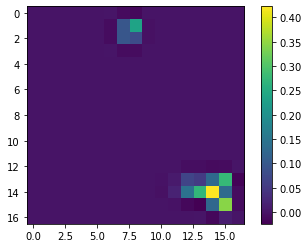

In [371]:
plt.imshow(ds2.GetRasterBand(32).ReadAsArray())
plt.colorbar()

In [281]:
0.6 * 17 / 30

0.33999999999999997

In [282]:
z.shape

(51, 51)

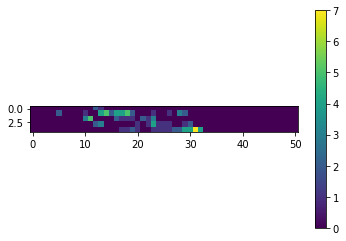

In [343]:
z, y, x = np.histogram2d(ex_fire_day['LATITUDE'], ex_fire_day['LONGITUDE'], 
                         bins=(5, 51), range=fbbox2)
z = np.flip(z, axis=0)

plt.imshow(z)
plt.colorbar()

In [325]:
height, width = z.shape
drv = gdal.GetDriverByName("GTiff")
ds = drv.Create("test5.tif", width, height, 1, gdal.GDT_Float32)
ds.GetRasterBand(1).WriteArray(z)
tr = np.asarray(test.GetGeoTransform())
tr[1] /= SCALE
tr[5] /= SCALE

ds.SetGeoTransform(tuple(tr))

0

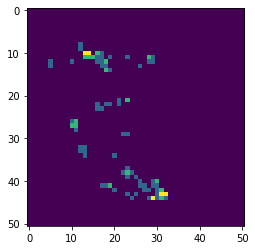

In [326]:
plt.imshow(ds.GetRasterBand(1).ReadAsArray())

In [330]:
tr = test.GetGeoTransform()
tr

(-106.08134681656745,
 0.011280197596173078,
 0.0,
 39.906611342985336,
 0.0,
 -0.008696695115915663)

In [348]:
ds2 = gdal.Warp('blah.vrt', ds, format='VRT', xRes=abs(tr[1]), yRes=abs(tr[5]), 
                     resampleAlg='cubic', outputBounds=fbbox)

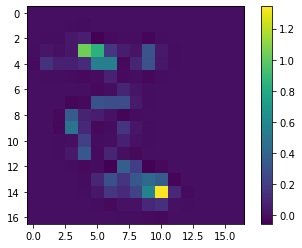

In [349]:
plt.imshow(ds2.GetRasterBand(1).ReadAsArray())
plt.colorbar()

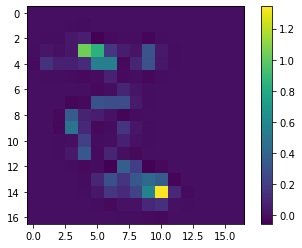

In [338]:
plt.imshow(ds2.GetRasterBand(1).ReadAsArray())
plt.colorbar()

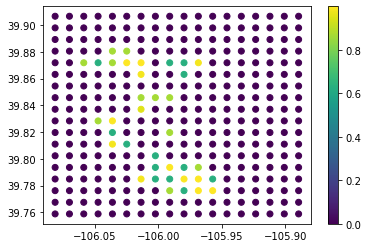

In [205]:
sample = r"C:\Users\mit\Documents\GitHub\wildfires\data\clean\fire_histories\11881214\20200823UTC120000.csv"
df = pd.read_csv(sample)
plt.scatter(df['lon'], df['lat'], c=df['on_fire'])
plt.colorbar()

In [164]:
in_path = 'data'
fxx=1

first = dt.datetime(2020, 1, 1, 12, 0)
first2 = dt.datetime(2020, 1, 1, 0, 0)
times = [(first + dt.timedelta(days=i)) for i in range(3)]
times2 = [(first2 + dt.timedelta(days=i)) for i in range(3)]
for time in times:
    direc = f'{in_path}/hrrr/{time.strftime("%Y%m%d")}'
    band_lookup = extract_hrrr(time, codes, 'data', fxx=fxx)
    hour = time.hour
    with open(f'{direc}/band_lookup_{hour}z_fxx{fxx}.json', 'w') as f:
        json.dump(band_lookup, f)
for time in times2:
    direc = f'{in_path}/hrrr/{time.strftime("%Y%m%d")}'
    band_lookup = extract_hrrr(time, codes, 'data', fxx=fxx)
    hour = time.hour
    with open(f'{direc}/band_lookup_{hour}z_fxx{fxx}.json', 'w') as f:
        json.dump(band_lookup, f)
# os.rename('data/hrrr', dropbox_path +'\\wildfire_repo\\hrrr')

🏋🏻‍♂️ Found 2020-Jan-01 12:00 UTC F01 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
2022-01-19 17:09:09.945601
2022-01-19 17:09:13.804208
🏋🏻‍♂️ Found 2020-Jan-02 12:00 UTC F01 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
2022-01-19 17:09:14.075283
2022-01-19 17:09:17.731982
🏋🏻‍♂️ Found 2020-Jan-03 12:00 UTC F01 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
2022-01-19 17:09:17.964025
2022-01-19 17:09:21.578655
🏋🏻‍♂️ Found 2020-Jan-01 00:00 UTC F01 [HRRR] [product=sfc] GRIB2 file fro

In [144]:
json.dumps(band_lookup, 'data/hrrr'

{'TMP:2 m': 3,
 'SPFH:2 m': 4,
 'UGRD:10 m': 5,
 'VGRD:10 m': 6,
 'LTNG': 1,
 'PRATE': 7,
 'PRES:surface': 2}

In [407]:
ds = gdal.Open(file)

bbox = [-110, 25, -75, 50]
hrrr = warp(ds, *bbox, *local_miles_per_lon_lat(bbox), 1, 'test.vrt')

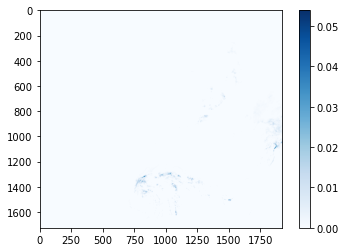

In [417]:
plt.imshow(hrrr.GetRasterBand(7).ReadAsArray(), cmap='Blues')
plt.colorbar()

In [252]:
b.RasterCount

173

In [253]:
comments = {i:b.GetRasterBand(i).GetMetadata()['GRIB_COMMENT'] for i in range(1, b.RasterCount+1)}
comments 

{1: 'Maximum / Composite radar reflectivity [dB]',
 2: 'Echo Top [m]',
 3: '(prodType 0, cat 16, subcat 201) [-]',
 4: 'Vertically-integrated liquid [kg/m]',
 5: 'Visibility [m]',
 6: 'Derived radar reflectivity [dB]',
 7: 'Derived radar reflectivity [dB]',
 8: 'Derived radar reflectivity [dB]',
 9: 'Wind speed (gust) [m/s]',
 10: 'u-component of wind [m/s]',
 11: 'v-component of wind [m/s]',
 12: 'u-component of wind [m/s]',
 13: 'v-component of wind [m/s]',
 14: 'Geopotential height [gpm]',
 15: 'Temperature [C]',
 16: 'Dew point temperature [C]',
 17: 'u-component of wind [m/s]',
 18: 'v-component of wind [m/s]',
 19: 'Geopotential height [gpm]',
 20: 'Temperature [C]',
 21: 'Dew point temperature [C]',
 22: 'Verical velocity (geometric) [m/s]',
 23: 'u-component of wind [m/s]',
 24: 'v-component of wind [m/s]',
 25: 'Geopotential height [gpm]',
 26: 'Temperature [C]',
 27: 'Dew point temperature [C]',
 28: 'u-component of wind [m/s]',
 29: 'v-component of wind [m/s]',
 30: 'Tempera

In [19]:
z, y, x = np.histogram2d(ex_fire['LATITUDE'], ex_fire['LONGITUDE'], bins=100, range=[[44.60, 44.95], [-122.17, -121.51]])
z = np.flip(z, axis=0)

NameError: name 'ex_fire' is not defined

In [20]:
x, y

NameError: name 'x' is not defined

In [489]:
np.unique(z, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 20., 22., 25.]),
 array([5567,  993,  925,  739,  541,  427,  247,  168,  132,   73,   61,
          37,   31,   16,   13,   11,   12,    2,    2,    1,    1,    1],
       dtype=int64))

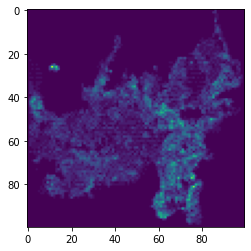

In [486]:
plt.imshow(z)

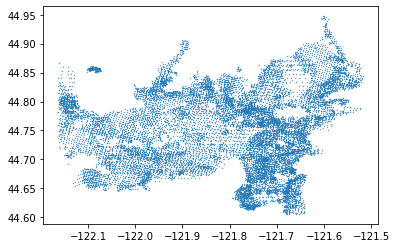

In [427]:
plt.scatter(ex_fire['LONGITUDE'], ex_fire['LATITUDE'], s=0.1)